<h1></h1>
<h2><center> ETI195 - Ética para Ciencia de Datos y Estadística </center></h2>

<h1></h1>
<h2><center> Taller 3: Métricas grupales, Aequitas </center></h2>



El objetivo de este taller es introducir el toolkit `Aequitas` y métricas grupales asociadas a fairness. En particular, veremos cómo obtener algunas métricas grupales que nos sirven para evaluar el comportamiento del algoritmo en los distintos grupos, primero mediante matrices de confusión (sklearn) y luego mediante `Aequitas`.

**Recomendación**: Leer el paper de Aequitas [1]. Pueden encontrarlo en el Drive/Github del taller, sección Material Extra.

[1] Saleiro, P., Kuester, B., Stevens, A., Anisfeld, A., Hinkson, L., London, J., & Ghani, R. (2018). Aequitas: A Bias and Fairness Audit Toolkit. CoRR, abs/1811.05577. http://arxiv.org/abs/1811.05577

## Imports

In [33]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from aequitas.group import Group

import warnings
warnings.filterwarnings('ignore')

## Recapitulación del taller pasado

<h2> COMPAS: Correctional Offender Management Profiling for Alternative Sanctions </h2>

![imagen](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/opener-b-crop-960*540-00796e.jpg)
<b><h6> Imagen 1 - Machine Bias (ProPublica) </h6></b>

- Algoritmo utilizado en el sistema de justicia criminal de Estados Unidos para predecir la probabilidad o riesgo de reincidencia de un acusado.

- Tiene por objetivo  ayudar a los jueces a tomar decisiones más informadas sobre el riesgo de reincidencia.

Investigación hecha por ProPublica: Existe una clara diferencia en la distribución de los puntajes de riesgo según raza.

<b><h3>Links de interés: </h3></b>

- [Artículo ProPublica : Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)

- [Metodología](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

- [Códigos originales de ProPublica](https://github.com/propublica/compas-analysis/tree/master)




In [34]:
compas = pd.read_csv(
    "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
)


compas.shape

(7214, 53)

In [35]:
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Columnas de interés:

1. `age` - Edad del acusado. Variable numérica.
2. `age_cat` - Categoría de edad. Puede ser < 25, 25-45, >45.
3. `sex` - Sexo del acusado. Puede ser  'Male' o 'Female'.
4. `race` - Raza del acusado. Puede ser 'African-American', 'Caucasian', 'Hispanic', 'Asian', o 'Other'.
5. `c_charge_degree` - Grado del crimen. Es o bien M (Misdemeanor), F (Felony), o O (Ordinary traffic offense).
6. `priors_count` - Número de crimenes anteriores cometidos por el acusado. Variable numérica.
7. `days_b_screening_arrest` - Días entre el arresto y la fecha del cargo por el delito registrado en COMPAS.
8. `decile_score` - Puntaje COMPAS predicho por el sistema. Toma valores entre 0 y 10.
9. `score_text` - Categoria de decile_score. Puede Low (1-4), Medium (5-7), y High (8-10).
10. `is_recid` - Variable que indica si un acusado es reincidente o no. Puede tomar valores 1, 0 o -1.
11. `two_year_recid` - Variable que indica si un acusado tuvo reincidencia dentro de un periodo de dos años.
12. `c_jail_in` - Momento en que el acusado fue ingresado a la carcel.
13. `c_jail_out` - Momento en que el acusado fue liberado de la carcel.

In [36]:
# Mantenemos las columnas de interés.

columns = [
    "age",
    "c_charge_degree",
    "race",
    "age_cat",
    "score_text",
    "sex",
    "priors_count",
    "days_b_screening_arrest",
    "decile_score",
    "is_recid",
    "two_year_recid",
    "c_jail_in",
    "c_jail_out",
]

compas = compas[columns]

In [37]:
compas.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
3,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
4,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


In [38]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      7214 non-null   int64  
 1   c_charge_degree          7214 non-null   object 
 2   race                     7214 non-null   object 
 3   age_cat                  7214 non-null   object 
 4   score_text               7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   priors_count             7214 non-null   int64  
 7   days_b_screening_arrest  6907 non-null   float64
 8   decile_score             7214 non-null   int64  
 9   is_recid                 7214 non-null   int64  
 10  two_year_recid           7214 non-null   int64  
 11  c_jail_in                6907 non-null   object 
 12  c_jail_out               6907 non-null   object 
dtypes: float64(1), int64(5), object(7)
memory usage: 732.8+ KB


En la metodología propuesta por ProPublica (revisar <b>Links de interés</b>) se presentan los siguientes criterios para realizar la limpieza de los datos:

- Si la fecha del cargo por el delito de un acusado evaluado por COMPAS no estaba dentro de los 30 días desde el momento en que la persona fue arrestada, asumimos que, debido a razones de calidad de datos, no tenemos el delito correcto.

- Según se indica en el código publicado por ProPublica, se etiquetó con ```is_recid = -1``` los casos para los cuales no se encontró el caso de COMPAS.

- En una línea similar, se eliminan las infracciones de tráfico comunes (aquellas con un grado de ```c_charge_degree``` <b>'O'</b>), que no resultarían en tiempo de prisión.


In [39]:
clean_df = compas[
    (
        (compas["days_b_screening_arrest"] <= 30)
        & (compas["days_b_screening_arrest"] >= -30)
        & (compas["is_recid"] != -1)
        & (compas["c_charge_degree"] != "O")
    )
]


clean_df.shape

(6172, 13)

In [40]:
compas.shape

(7214, 13)

In [41]:
print(f"Se eliminaron {compas.shape[0] - clean_df.shape[0]} registros.")

Se eliminaron 1042 registros.


In [42]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      6172 non-null   int64  
 1   c_charge_degree          6172 non-null   object 
 2   race                     6172 non-null   object 
 3   age_cat                  6172 non-null   object 
 4   score_text               6172 non-null   object 
 5   sex                      6172 non-null   object 
 6   priors_count             6172 non-null   int64  
 7   days_b_screening_arrest  6172 non-null   float64
 8   decile_score             6172 non-null   int64  
 9   is_recid                 6172 non-null   int64  
 10  two_year_recid           6172 non-null   int64  
 11  c_jail_in                6172 non-null   object 
 12  c_jail_out               6172 non-null   object 
dtypes: float64(1), int64(5), object(7)
memory usage: 675.1+ KB


In [43]:
age_count = clean_df["age_cat"].value_counts(normalize=True) * 100
race_count = clean_df["race"].value_counts(normalize=True) * 100
sex_count = clean_df["sex"].value_counts(normalize=True) * 100

## Pre - procesamiento (del taller previo)


In [44]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      6172 non-null   int64  
 1   c_charge_degree          6172 non-null   object 
 2   race                     6172 non-null   object 
 3   age_cat                  6172 non-null   object 
 4   score_text               6172 non-null   object 
 5   sex                      6172 non-null   object 
 6   priors_count             6172 non-null   int64  
 7   days_b_screening_arrest  6172 non-null   float64
 8   decile_score             6172 non-null   int64  
 9   is_recid                 6172 non-null   int64  
 10  two_year_recid           6172 non-null   int64  
 11  c_jail_in                6172 non-null   object 
 12  c_jail_out               6172 non-null   object 
dtypes: float64(1), int64(5), object(7)
memory usage: 675.1+ KB


In [45]:
object_columns = clean_df.select_dtypes(include="object").columns
for objcol in object_columns:
    print(f"Columna {objcol}: {clean_df[objcol].unique()}")

Columna c_charge_degree: ['F' 'M']
Columna race: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
Columna age_cat: ['Greater than 45' '25 - 45' 'Less than 25']
Columna score_text: ['Low' 'Medium' 'High']
Columna sex: ['Male' 'Female']
Columna c_jail_in: ['2013-08-13 06:03:42' '2013-01-26 03:45:27' '2013-04-13 04:58:34' ...
 '2014-01-13 05:48:01' '2014-03-08 08:06:02' '2014-06-28 12:16:41']
Columna c_jail_out: ['2013-08-14 05:41:20' '2013-02-05 05:36:53' '2013-04-14 07:02:04' ...
 '2014-01-14 07:49:46' '2014-03-09 12:18:04' '2014-06-30 11:19:23']


In [46]:
object_columns = [
    x
    for x in clean_df.select_dtypes(include="object").columns
    if x != "c_jail_in" and x != "c_jail_out"
]


for objcol in object_columns:


    clean_df[objcol] = clean_df[objcol].astype("category")

In [47]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      6172 non-null   int64   
 1   c_charge_degree          6172 non-null   category
 2   race                     6172 non-null   category
 3   age_cat                  6172 non-null   category
 4   score_text               6172 non-null   category
 5   sex                      6172 non-null   category
 6   priors_count             6172 non-null   int64   
 7   days_b_screening_arrest  6172 non-null   float64 
 8   decile_score             6172 non-null   int64   
 9   is_recid                 6172 non-null   int64   
 10  two_year_recid           6172 non-null   int64   
 11  c_jail_in                6172 non-null   object  
 12  c_jail_out               6172 non-null   object  
dtypes: category(5), float64(1), int64(5), object(2)
memory usage: 464.8+

In [48]:
clean_df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


In [49]:
pd.get_dummies(clean_df["race"]).head()

,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,False,False,False,False,False,True
1,True,False,False,False,False,False
2,True,False,False,False,False,False
5,False,False,False,False,False,True
6,False,False,True,False,False,False


In [50]:
post_df = clean_df.copy()

In [51]:
dummies = pd.get_dummies(post_df["race"])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=["race", "Caucasian"], inplace=True)

In [52]:
clean_df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


In [53]:
dummies = pd.get_dummies(post_df["age_cat"])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=["age_cat", "25 - 45"], inplace=True)

In [54]:
dummies = pd.get_dummies(post_df["sex"])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=["sex", "Male"], inplace=True)

In [55]:
dummies = pd.get_dummies(post_df["c_charge_degree"])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=["c_charge_degree", "F"], inplace=True)

In [56]:
post_df.head()

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,African-American,Asian,Hispanic,Native American,Other,Greater than 45,Less than 25,Female,M
0,69,Low,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,False,False,False,False,True,True,False,False,False
1,34,Low,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,True,False,False,False,False,False,False,False,False
2,24,Low,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,True,False,False,False,False,False,True,False,False
5,44,Low,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,False,False,False,False,True,False,False,False,True
6,41,Medium,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,False,False,False,False,False,False,False,False,False


Lo primero será convertir la variable `score_text` a binario. Para ello, mapearemos `Low` $\to$ 0, `Medium` $\to$ 1, `High` $\to$ 1.

In [57]:
post_df["score_text"] = post_df["score_text"].map({"Low": 0, "Medium": 1, "High": 1})
post_df.head()

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,African-American,Asian,Hispanic,Native American,Other,Greater than 45,Less than 25,Female,M
0,69,0,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,False,False,False,False,True,True,False,False,False
1,34,0,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,True,False,False,False,False,False,False,False,False
2,24,0,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,True,False,False,False,False,False,True,False,False
5,44,0,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,False,False,False,False,True,False,False,False,True
6,41,1,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,False,False,False,False,False,False,False,False,False


Rename de columnas:

In [58]:
post_df.rename(
    columns={
        "Native American": "Native_American",
        "Greater than 45": "Greater_than_45",
        "Less than 25": "Less_than_25",
        "African-American": "African_American",
    },
    inplace=True,
)


post_df.head()

,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,African_American,Asian,Hispanic,Native_American,Other,Greater_than_45,Less_than_25,Female,M
0,69,0,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,False,False,False,False,True,True,False,False,False
1,34,0,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,True,False,False,False,False,False,False,False,False
2,24,0,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,True,False,False,False,False,False,True,False,False
5,44,0,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,False,False,False,False,True,False,False,False,True
6,41,1,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,False,False,False,False,False,False,False,False,False


## Conceptos preliminares y métricas (extraídas del paper de Aequitas)

![Conceptos Preliminares](https://github.com/dssg/aequitas/blob/master/docs/_images/preliminary_concepts.jpg?raw=true)

![Métricas](https://github.com/dssg/aequitas/blob/master/docs/_images/metrics.jpg?raw=true)

## Obteniendo las métricas a través de matrices de confusión

In [59]:
# Datos por sexo
male_data = post_df[post_df["Female"] == 0]
female_data = post_df[post_df["Female"] == 1]

# Datos por raza
am_data = post_df[post_df["African_American"] == 1]

cau_data = post_df[
    (
        (post_df["African_American"] == 0)
        & (post_df["Asian"] == 0)
        & (post_df["Native_American"] == 0)
        & (post_df["Hispanic"] == 0)
    )
]

# Datos por categoria de edad
less25_data = post_df[post_df["Less_than_25"] == 1]
greater45_data = post_df[post_df["Greater_than_45"] == 1]

from25to45_data = post_df[
    ((post_df["Less_than_25"] == 0) & (post_df["Greater_than_45"] == 0))
]


labels = ["No Reincide", "Reincide"]

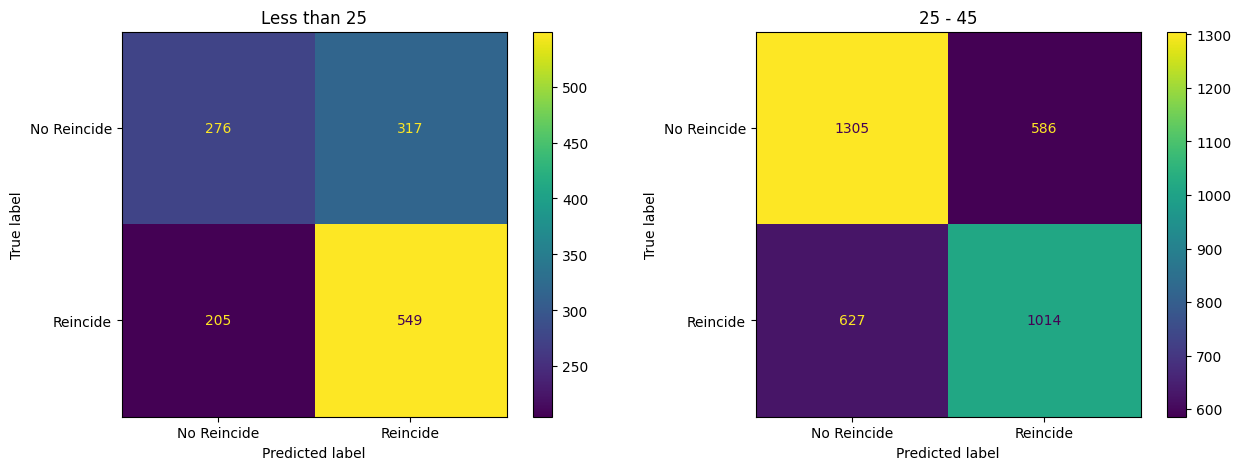

In [60]:
# Comparando matrices de confusión por grupo etáreo (absoluta).

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
cm1 = ConfusionMatrixDisplay(
    confusion_matrix(less25_data["two_year_recid"], less25_data["score_text"]),
    display_labels=labels,
)
cm2 = ConfusionMatrixDisplay(
    confusion_matrix(from25to45_data["two_year_recid"], from25to45_data["score_text"]),
    display_labels=labels,
)

cm1.plot(ax=ax[0])
cm2.plot(ax=ax[1])

ax[0].set_title("Less than 25")
ax[1].set_title("25 - 45")
plt.show()

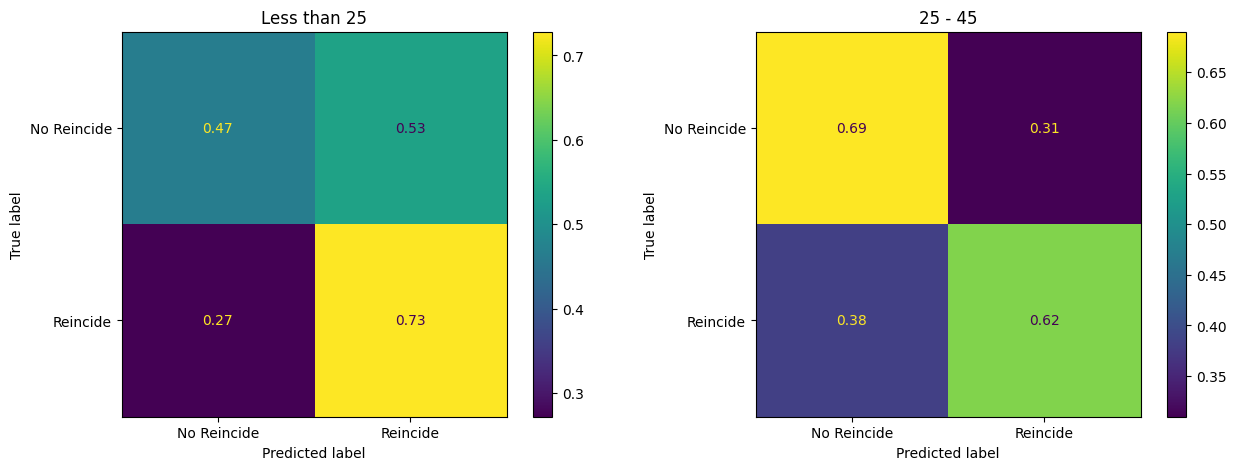

In [61]:
# Comparando matrices de confusión por grupo etáreo (relativa a las etiquetas: FPR, FNR).
# Con el parámetro normalize="true".

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
cm1 = ConfusionMatrixDisplay(
    confusion_matrix(
        less25_data["two_year_recid"], less25_data["score_text"], normalize="true"
    ),
    display_labels=labels,
)
cm2 = ConfusionMatrixDisplay(
    confusion_matrix(
        from25to45_data["two_year_recid"],
        from25to45_data["score_text"],
        normalize="true",
    ),
    display_labels=labels,
)

cm1.plot(ax=ax[0])
cm2.plot(ax=ax[1])

ax[0].set_title("Less than 25")
ax[1].set_title("25 - 45")
plt.show()

![imagen](https://miro.medium.com/v2/resize:fit:1400/1*VSchph99Wiv6tQpNIvMJbw.png)


Vemos que el FPR para el grupo de menores de 25 años es de 0.53 mientras que el FPR para el grupo de entre 25 y 45 años es de 0.31 $\to$ Las predicciones del algoritmo tienden a equivocarse más etiquetando como reincidente a aquellos que no reindiden en el grupo de menores de 25 años respecto del grupo de entre 25 y 45 años.

Por otro lado, el FNR para el grupo de menores de 25 años es de 0.27 mientras que el FPR para el grupo de entre 25 y 45 años es de 0.38 $\to$ Las predicciones del algoritmo tienden a equivocarse más etiquetando como no reincidente a aquellos que sí reinciden en el grupo de entre 25 y 45 años respecto del grupo de menores de 25 años.

In [62]:
conf = confusion_matrix(
    less25_data["two_year_recid"], less25_data["score_text"], normalize="true"
).flatten()


conf

array([0.46543002, 0.53456998, 0.27188329, 0.72811671])

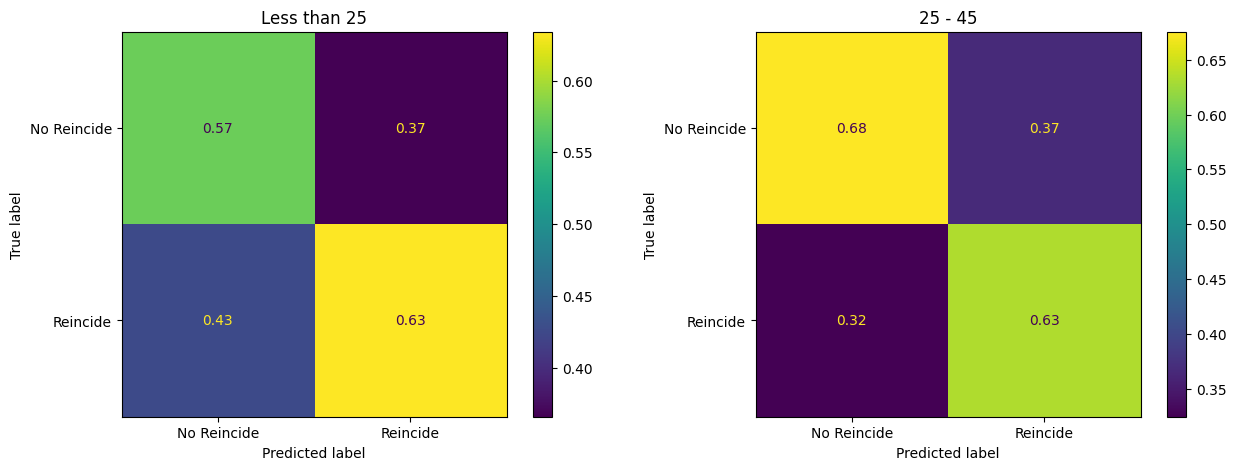

In [79]:
# Comparando matrices de confusión por grupo etáreo (relativa a las predicciones: FDR, FOR).
# Nótese el normalize="pred", que cambia el eje de normalización.

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()
cm1 = ConfusionMatrixDisplay(
    confusion_matrix(
        less25_data["two_year_recid"], less25_data["score_text"], normalize="pred"
    ),
    display_labels=labels,
)
cm2 = ConfusionMatrixDisplay(
    confusion_matrix(
        from25to45_data["two_year_recid"],
        from25to45_data["score_text"],
        normalize="pred",
    ),
    display_labels=labels,
)

cm1.plot(ax=ax[0])
cm2.plot(ax=ax[1])

ax[0].set_title("Less than 25")
ax[1].set_title("25 - 45")
plt.show()

El FOR (False Omission Rate) es mayor en el grupo de menores de 25 años que en el grupo de 25 a 45
años $\to$ El algoritmo "deja pasar" más casos positivos (se le escapan) en el grupo de menores de
25 años que en el grupo de 25 a 45 años.

0.43 > 0.32

Una versión normalizada facilita la interpretación visual de cómo se están prediciendo las
etiquetas, además de permitir comparaciones. 

También se puede pasar el parámetro `values_format='.0%'` para
mostrar los valores como porcentajes. El parámetro `normalize` especifica qué se debe usar como
denominador:

- `'true'`: suma de las filas (Etiqueta verdadera)
- `'pred'`: suma de las columnas (Etiqueta predicha)
- `'all'`: suma de todos


![imagen](https://miro.medium.com/v2/resize:fit:1400/1*o9HNABfdXQG-UhzmfpgQxA.png)

In [64]:
# Teníamos los datos de esta forma.

clean_df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


Para utilizar Aequitas con nuestros datos, estos deben tener una estructura en específico. Los detalles se encuentran en la [Documentación de Aequitas](https://dssg.github.io/aequitas/input_data.html#Input-data-for-Python-package).

In [65]:
# Seleccionamos las columnas necesarias.

df = clean_df[["score_text", "two_year_recid", "race", "age_cat", "sex"]]
df.head()

,score_text,two_year_recid,race,age_cat,sex
0,Low,0,Other,Greater than 45,Male
1,Low,1,African-American,25 - 45,Male
2,Low,1,African-American,Less than 25,Male
5,Low,0,Other,25 - 45,Male
6,Medium,1,Caucasian,25 - 45,Male


In [66]:
# score_text a variable binaria.

df["score_text"] = df["score_text"].map({"Low": 0, "Medium": 1, "High": 1})
df.head()

,score_text,two_year_recid,race,age_cat,sex
0,0,0,Other,Greater than 45,Male
1,0,1,African-American,25 - 45,Male
2,0,1,African-American,Less than 25,Male
5,0,0,Other,25 - 45,Male
6,1,1,Caucasian,25 - 45,Male


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   score_text      6172 non-null   int64   
 1   two_year_recid  6172 non-null   int64   
 2   race            6172 non-null   category
 3   age_cat         6172 non-null   category
 4   sex             6172 non-null   category
dtypes: category(3), int64(2)
memory usage: 163.2 KB


In [68]:
cat_cols = df.select_dtypes(include="category").columns
for col in cat_cols:
    df[col] = df[col].astype(str)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   score_text      6172 non-null   int64 
 1   two_year_recid  6172 non-null   int64 
 2   race            6172 non-null   object
 3   age_cat         6172 non-null   object
 4   sex             6172 non-null   object
dtypes: int64(2), object(3)
memory usage: 289.3+ KB


In [70]:
# Renombrar las columnas

df.rename(
    columns={"score_text": "score", "two_year_recid": "label_value"}, inplace=True
)

In [71]:
df.head()

,score,label_value,race,age_cat,sex
0,0,0,Other,Greater than 45,Male
1,0,1,African-American,25 - 45,Male
2,0,1,African-American,Less than 25,Male
5,0,0,Other,25 - 45,Male
6,1,1,Caucasian,25 - 45,Male


In [72]:
group = Group()
xtab, _ = group.get_crosstabs(df)

In [73]:
xtab.head()

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,2751,race,African-American,0.649134,0.715232,0.576618,0.351412,0.350465,...,0.576063,641,473,873,1188,1661,1514,3175,6172,0.523150
1,0,binary 0/1,2751,race,Asian,0.838710,0.625000,0.913043,0.125000,0.285714,...,0.225806,2,3,21,5,8,23,31,6172,0.258065
2,0,binary 0/1,2751,race,Caucasian,0.671897,0.503650,0.779859,0.289979,0.405172,...,0.330956,282,408,999,414,822,1281,2103,6172,0.390870
3,0,binary 0/1,2751,race,Hispanic,0.662083,0.417989,0.806250,0.298913,0.439716,...,0.277014,62,110,258,79,189,320,509,6172,0.371316
4,0,binary 0/1,2751,race,Native American,0.727273,1.000000,0.500000,0.000000,0.375000,...,0.727273,3,0,3,5,5,6,11,6172,0.454545


In [74]:
xtab.columns

Index(['model_id', 'score_threshold', 'k', 'attribute_name', 'attribute_value',
       'accuracy', 'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv',
       'precision', 'pp', 'pn', 'ppr', 'pprev', 'fp', 'fn', 'tn', 'tp',
       'group_label_pos', 'group_label_neg', 'group_size', 'total_entities',
       'prev'],
      dtype='object')

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


In [75]:
absolute_metrics = group.list_absolute_metrics(xtab)
absolute_metrics

['accuracy',
 'tpr',
 'tnr',
 'for',
 'fdr',
 'fpr',
 'fnr',
 'npv',
 'precision',
 'ppr',
 'pprev',
 'prev']

In [76]:
absolute_xtab = xtab[["attribute_name", "attribute_value"] + absolute_metrics]
absolute_xtab

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.649134,0.715232,0.576618,0.351412,0.350465,0.423382,0.284768,0.648588,0.649535,0.664849,0.576063,0.523150
1,race,Asian,0.838710,0.625000,0.913043,0.125000,0.285714,0.086957,0.375000,0.875000,0.714286,0.002545,0.225806,0.258065
2,race,Caucasian,0.671897,0.503650,0.779859,0.289979,0.405172,0.220141,0.496350,0.710021,0.594828,0.252999,0.330956,0.390870
3,race,Hispanic,0.662083,0.417989,0.806250,0.298913,0.439716,0.193750,0.582011,0.701087,0.560284,0.051254,0.277014,0.371316
4,race,Native American,0.727273,1.000000,0.500000,0.000000,0.375000,0.500000,0.000000,1.000000,0.625000,0.002908,0.727273,0.454545
5,race,Other,0.679300,0.338710,0.872146,0.300366,0.400000,0.127854,0.661290,0.699634,0.600000,0.025445,0.204082,0.361516
6,age_cat,25 - 45,0.656569,0.617916,0.690111,0.324534,0.366250,0.309889,0.382084,0.675466,0.633750,0.581607,0.453001,0.464609
7,age_cat,Greater than 45,0.722351,0.410628,0.869170,0.242063,0.403509,0.130830,0.589372,0.757937,0.596491,0.103599,0.220418,0.320186
8,age_cat,Less than 25,0.612472,0.728117,0.465430,0.426195,0.366051,0.534570,0.271883,0.573805,0.633949,0.314795,0.642910,0.559762
9,sex,Female,0.662128,0.595642,0.698163,0.238913,0.483193,0.301837,0.404358,0.761087,0.516807,0.173028,0.405106,0.351489


In [77]:
xtab.shape

(11, 27)